# New York CITY BIKE - Data Analysis and Trip Duration Prediction


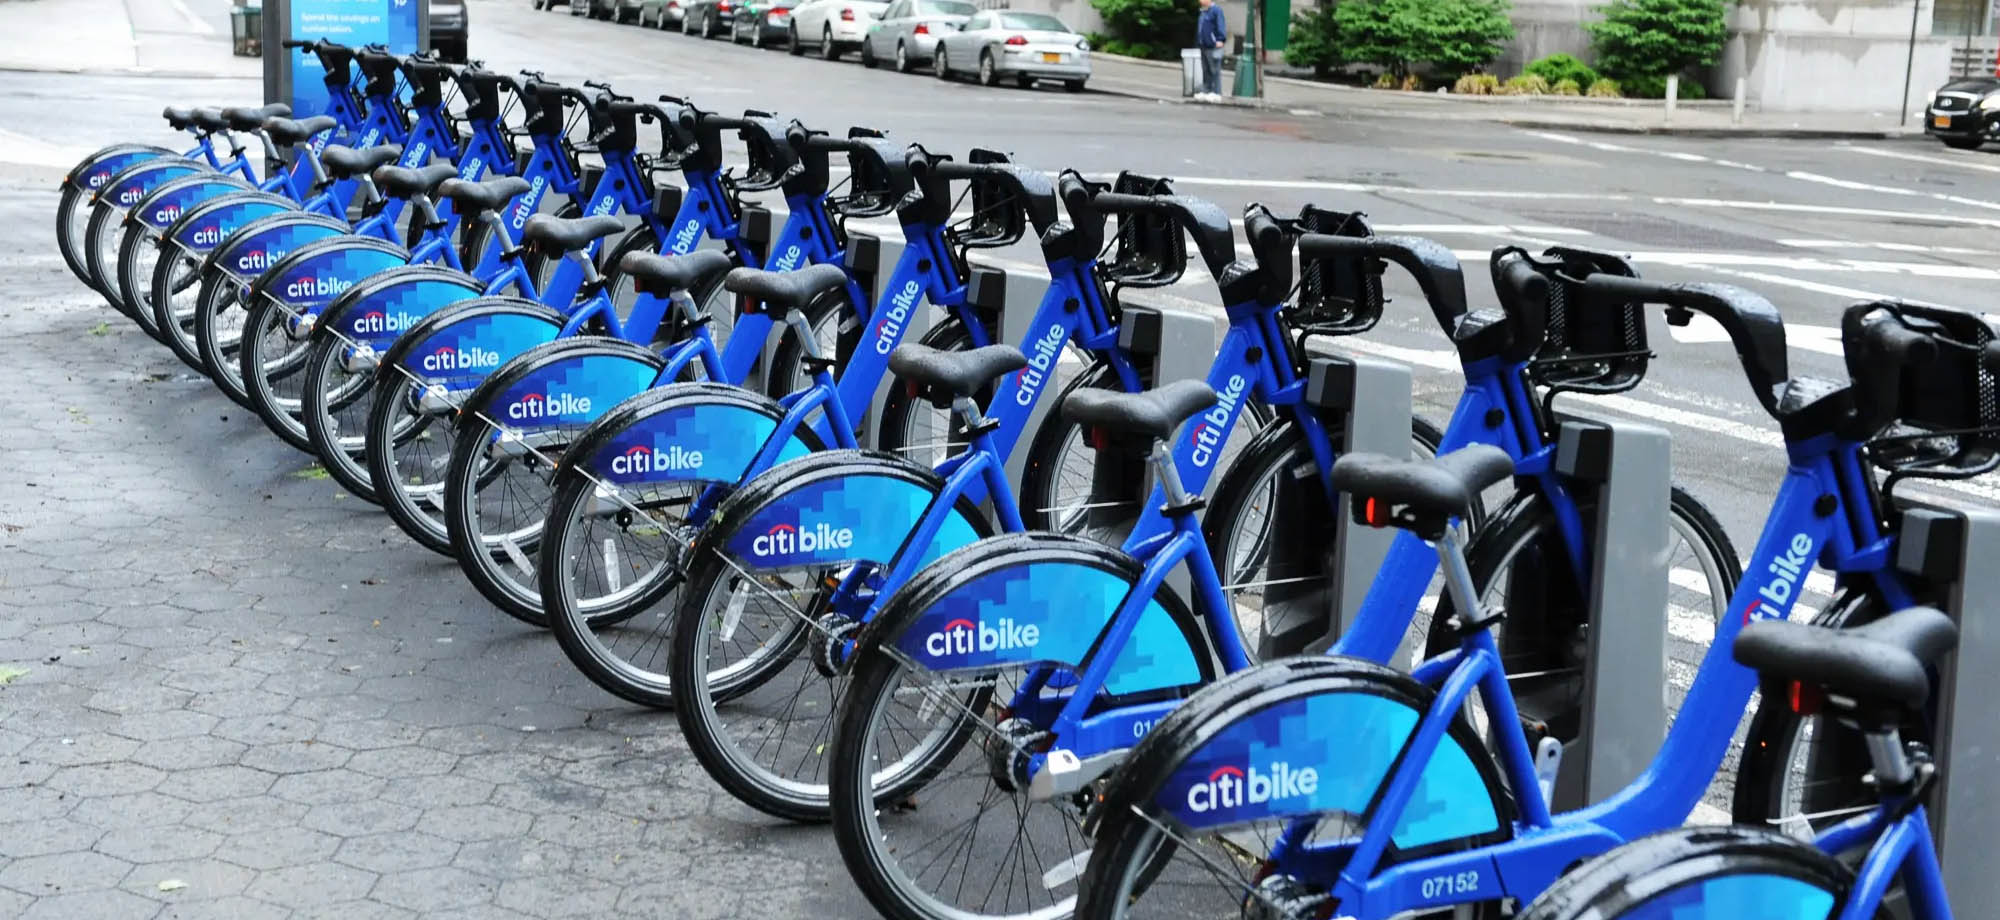

### Goals
- Build a reliable model to predict trip duration based on factors like station distance, day of the week, and time of day.
- Identify key factors influencing the number of trips, such as weather conditions and peak usage times
- Leverage data insights to enhance station management, resource allocation, and overall service efficiency.
### Business Benefits
- **Operational efficiency:** The model helps optimize bike station locations by understanding how station distance impacts trip duration, improving resource allocation.

- **Demand forecasting:** Predicting the number of trips based on factors like weather and time of day enables better fleet management and service planning.

- **Enhanced customer experience:** Insights into trip patterns allow for tailored services, improving user satisfaction and retention by aligning availability with peak demand times.

### Data Source
https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-citi-bike

### Data Description
The full dataset includes data on 58,937,715 trips since 2013. The data used for the project is for 2018 only (16,5 millions rows).


| field name | mode | type | description |
| --- | --- | --- | --- |
| tripduration | NULLABLE | INTEGER | Trip Duration (in seconds) |
| starttime | NULLABLE | DATETIME | Start Time, in NYC local time. |
| stoptime | NULLABLE | DATETIME | Stop Time, in NYC local time. |
| start_station_id | NULLABLE | INTEGER | Start Station ID |
| start_station_name | NULLABLE | STRING | Start Station Name |
| start_station_latitude | NULLABLE | FLOAT | Start Station Latitude |
| start_station_longitude | NULLABLE | FLOAT | Start Station Longitude |
| end_station_id | NULLABLE | INTEGER | End Station ID |
| end_station_name | NULLABLE | STRING | End Station Name |
| end_station_latitude | NULLABLE | FLOAT | End Station Latitude |
| end_station_longitude | NULLABLE | FLOAT | End Station Longitude |
| bikeid | NULLABLE | INTEGER | Bike ID |
| usertype | NULLABLE | STRING | User Type (Customer = 24-hour pass or 7-day pass user, Subscriber = Annual Member) |
| birth_year | NULLABLE | INTEGER | Year of Birth |
| gender | NULLABLE | STRING | Gender (unknown, male, female) |
| customer_plan | NULLABLE | STRING | The name of the plan that determines the rate charged for the trip |

## Retrieving data

In [ ]:
from google.cloud import bigquery
from google.colab import auth

#@title Provide Google Credentials to Colab Runtime
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#@title Enter Google Cloud/BigQuery Project ID
project_id = 'city-bike-trips-435211' #@param{type:"string"}

# Creating BigQuery client
bq_client = bigquery.Client(project = project_id)

In [ ]:
#@title Retrieving trips data
%%bigquery trips --project {project_id}

SELECT
  tripduration,
  starttime,
  DATE(starttime) AS date,
  CAST(EXTRACT(DAYOFWEEK FROM starttime) AS INT64) AS day_of_week,
  CAST(EXTRACT(HOUR FROM starttime) AS INT64) AS hour_of_day,
  CAST(EXTRACT(MONTH FROM starttime) AS INT64) AS month,
  start_station_name,
  end_station_name,
  start_station_latitude,
  start_station_longitude,
  end_station_latitude,
  end_station_longitude,
  start_station_id,
  end_station_id,
  # Calculating the distance between the start and end stations in kilometers.
  # Using Haversine formula to measure the great-circle distance between two points on a sphere given their longitudes and latitudes.
  (6371 * 2 * ASIN(SQRT(POWER(SIN((end_station_latitude - start_station_latitude) * 3.141592653589793 / 180 / 2), 2) +
  COS(start_station_latitude * 3.141592653589793 / 180) * COS(end_station_latitude * 3.141592653589793 / 180) * POWER(SIN((end_station_longitude -  start_station_longitude) * 3.141592653589793 / 180 / 2), 2)))) AS distance_km,
  usertype,
  CAST(EXTRACT(YEAR FROM starttime) AS INT64) - birth_year AS age,
  gender
FROM `bigquery-public-data.new_york_citibike.citibike_trips` trips
WHERE starttime IS NOT NULL AND stoptime IS NOT NULL AND starttime >= '2017-04-01' and starttime < '2018-04-01'
ORDER BY starttime DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(f'Total rows: {trips.index.size}')
trips.head()

Total rows: 16657449


,tripduration,starttime,date,day_of_week,hour_of_day,month,start_station_name,end_station_name,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id,end_station_id,distance_km,usertype,age,gender
0,568,2018-03-31 23:59:58.172,2018-03-31,7,23,3,W 21 St & 6 Ave,E 20 St & FDR Drive,40.741740,-73.994156,40.733143,-73.975739,435,487,1.822507,Subscriber,22,male
1,482,2018-03-31 23:59:56.244,2018-03-31,7,23,3,Kent Ave & N 7 St,India St & West St,40.720368,-73.961651,40.731814,-73.959950,3016,3469,1.280808,Subscriber,39,male
2,533,2018-03-31 23:59:49.677,2018-03-31,7,23,3,W 41 St & 8 Ave,E 39 St & 2 Ave,40.756405,-73.990026,40.747804,-73.973442,477,518,1.693036,Subscriber,48,male
3,297,2018-03-31 23:59:38.086,2018-03-31,7,23,3,Amsterdam Ave & W 73 St,W 84 St & Columbus Ave,40.779668,-73.980930,40.785000,-73.972834,3167,3170,0.903425,Subscriber,38,male
4,971,2018-03-31 23:59:34.979,2018-03-31,7,23,3,Avenue D & E 3 St,W 26 St & 10 Ave,40.720828,-73.977932,40.749718,-74.002950,302,388,3.842235,Subscriber,33,female


## Detecting and Handling Missing values and Outliers

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16657449 entries, 0 to 16657448
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             Int64         
 1   starttime                datetime64[us]
 2   date                     dbdate        
 3   day_of_week              Int64         
 4   hour_of_day              Int64         
 5   month                    Int64         
 6   start_station_latitude   float64       
 7   start_station_longitude  float64       
 8   end_station_latitude     float64       
 9   end_station_longitude    float64       
 10  start_station_id         Int64         
 11  end_station_id           Int64         
 12  distance_km              float64       
 13  usertype                 object        
 14  age                      Int64         
 15  gender                   object        
dtypes: Int64(7), datetime64[us](1), dbdate(1), float64(5), object(2)
memor

In [ ]:
trips.isnull().sum()

,0
tripduration,0
starttime,0
date,0
day_of_week,0
hour_of_day,0
month,0
start_station_latitude,0
start_station_longitude,0
end_station_latitude,0
end_station_longitude,0


In [ ]:
print(f"""
  Age: {trips['age'].unique()}\n
  Gender: {trips['gender'].unique()}\n
  Usertype: {trips['usertype'].unique()}\n
  tripduration: max - {trips['tripduration'].max()}, min - {trips['tripduration'].min()}\n
  distance_km: max - {trips['distance_km'].max()}, min - {trips['distance_km'].min()}\n
  start_station_latitude: max - {trips['start_station_latitude'].max()}, min - {trips['start_station_latitude'].min()}\n
  start_station_longitude: max - {trips['start_station_longitude'].max()}, min - {trips['start_station_longitude'].min()}\n
  end_station_latitude: max - {trips['end_station_latitude'].max()}, min - {trips['end_station_latitude'].min()}\n
  end_station_longitude: max - {trips['end_station_longitude'].max()}, min - {trips['end_station_longitude'].min()}\n
  """)


  Age: <IntegerArray>
[ 22,  39,  48,  38,  33,  23,  43,  25,  26,  30,
 ...
 107,  91, 110, 127,  90, 104, 122, 112, 121, 143]
Length: 110, dtype: Int64

  Gender: ['male' 'female' 'unknown']

  Usertype: ['Subscriber' 'Customer']

  tripduration: max - 19510049, min - 61

  distance_km: max - 8672.622943711138, min - 0.0

  start_station_latitude: max - 45.506364054011385, min - 0.0

  start_station_longitude: max - 0.0, min - -74.03423398733139

  end_station_latitude: max - 45.506364054011385, min - 0.0

  end_station_longitude: max - 0.0, min - -74.0858489

  


In [ ]:
trips[['tripduration', 'distance_km', 'age']].describe()

,tripduration,distance_km,age
count,16657449.0,1.665745e+07,15138359.0
mean,1001.858564,1.837943e+00,38.234789
std,19912.404628,1.537973e+01,11.868241
min,61.0,0.000000e+00,16.0
25%,368.0,8.497305e-01,29.0
50%,616.0,1.404479e+00,35.0
75%,1070.0,2.341818e+00,47.0
max,19510049.0,8.672623e+03,143.0


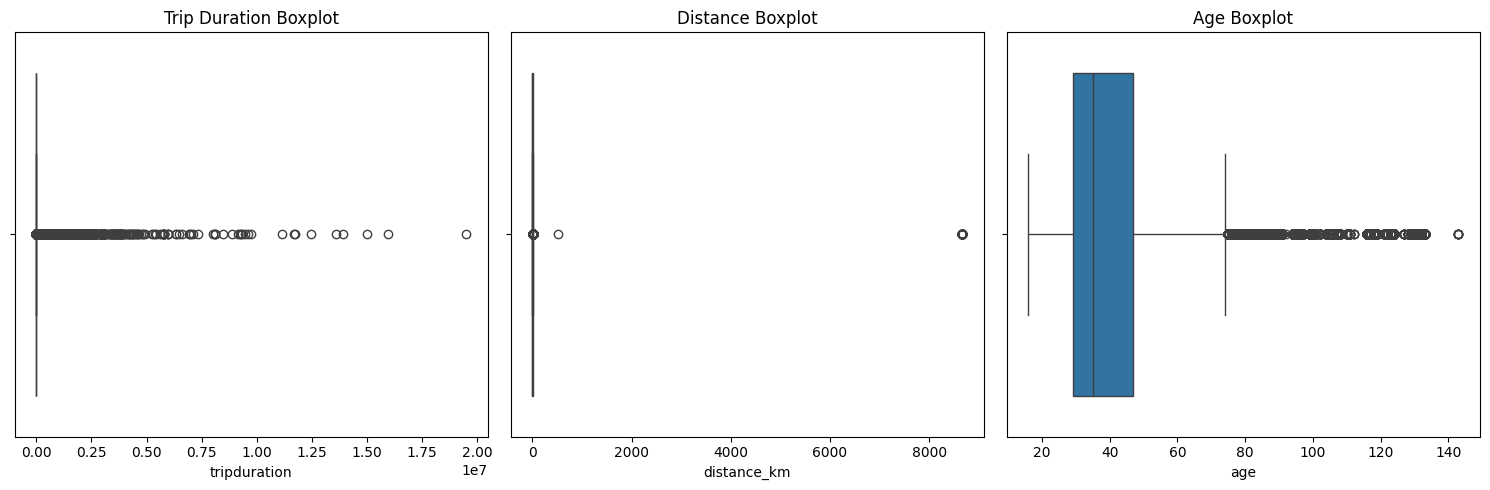

In [ ]:
#@title Creating plots to detect outliers

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tripduration
sns.boxplot(x='tripduration', data=trips, ax=axes[0])
axes[0].set_title('Trip Duration Boxplot')

# Distance
sns.boxplot(x='distance_km', data=trips, ax=axes[1])
axes[1].set_title('Distance Boxplot')

# Age
sns.boxplot(x='age', data=trips, ax=axes[2])
axes[2].set_title('Age Boxplot')

plt.tight_layout()
plt.show()


1. There are a significant number of outliers in the each plot. On the right plot it indicating that some trips have unusually high durations compared to the majority.Most of the data is concentrated near the lower end, suggesting that the majority of trips are relatively short. Investigating and possibly capping or removing these extreme values could improve the prediction model.
2. Similar to trip duration, there are extreme outliers in the distance data. A small number of trips cover extraordinarily large distances. Most distances are tightly packed near the lower end, meaning the majority of trips cover relatively short distances. The presence of extreme outliers in distance may indicate potential issues with data recording.
3. The age distribution is much more balanced compared to trip duration and distance, with a larger interquartile range (IQR). There are outliers on the higher end, including some extreme values above 100 years, which seem unrealistic for typical bike riders.

In [ ]:
trips = trips[trips['start_station_latitude'] != '0.0']
trips = trips[trips['start_station_longitude'] != '0.0']
trips = trips[trips['end_station_latitude'] != '0.0']
trips = trips[trips['end_station_longitude'] != '0.0']

In [ ]:
#@title Handling missing values and outliers of age

# Calculate the IQR (Interquartile Range)
Q1 = trips['age'].quantile(0.25)
Q3 = trips['age'].quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out outliers
age_outliers = trips[
    (trips['age'] <= lower_bound) | (trips['age'] >= upper_bound)
]

mean_age = trips['age'].mean()
std_age = IQR / 1.35  # Approximation of standard deviation from IQR

# Generate random ages using a normal distribution within the lower and upper age range
random_ages_null = np.random.normal(loc=mean_age, scale=std_age, size=trips['age'].isnull().sum())
random_ages_outliers = np.random.normal(loc=mean_age, scale=std_age, size=age_outliers.index.size)

# Clip the values to ensure they remain within a reasonable age range (lower_age, upper_age)
random_ages_null = np.clip(random_ages_null, Q1, Q3)
random_ages_outliers = np.clip(random_ages_outliers, Q1, Q3)

# Convert the random ages to integers
random_ages_null = random_ages_null.astype(int)
random_ages_outliers = random_ages_outliers.astype(int)
# Fill missing age values with the generated random integer values
trips.loc[trips['age'].isnull(), 'age'] = random_ages_null
trips.loc[age_outliers.index, 'age'] = random_ages_outliers


In [ ]:
print(f"Min. age: {trips['age'].min()}, Max age: {trips['age'].max()}")

Min. age: 16, Max age: 73


In [ ]:
#@title Handling outliers of tripduration

# Calculate the IQR (Interquartile Range)
Q1 = trips['tripduration'].quantile(0.25)
Q3 = trips['tripduration'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
trips = trips[
    (trips['tripduration'] >= lower_bound) & (trips['tripduration'] <= upper_bound)
]

print(trips.index.size)

15933017


In [ ]:
#@title Handling outliers of distance_km
# Calculating the IQR (Interquartile Range)
Q1 = trips['distance_km'].quantile(0.25)
Q3 = trips['distance_km'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
trips = trips[(trips['distance_km'] >= lower_bound) & (trips['distance_km'] <= upper_bound)]

print(trips.index.size)

15181484


## Exploratory Data Analysis

In [ ]:
# Group by date and count the number of trips
trips_per_date = trips.groupby('date').size().reset_index(name='count')

# Creating a lineplote with number of trips per date
plt.figure(figsize=(18, 6))
fig = px.line(trips_per_date, x='date', y='count', title='Number of Citi Bike Trips per Day', height=600)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Number of Trips')
fig.show()


<Figure size 1800x600 with 0 Axes>

1. There is a seasonal pattern, with higher trip counts observed during warmer months (late spring to fall) and a noticeable drop during colder months (winter).
2. Some extreme dips are visible, which may indicate outliers or specific events like holidays or weather disruptions that significantly affected biking activity.
3. During the summer of 2017, the highest number of trips reached nearly 70,000 per day, while the winter months show trip counts as low as around 10,000.

This seasonality and variability should be considered when developing prediction models for trip duration, as weather and time of year are likely to be important features.

In [ ]:
#@title Distribution of trips by day_of_week
# Group by day_of_week and count the number of trips
trips_by_day_of_week = trips.groupby('day_of_week').size().reset_index(name='count')

# Creating a bar chart using Plotly Express
fig = px.bar(trips_by_day_of_week, x='day_of_week', y='count',
             labels={'day_of_week': 'Day of the Week', 'count': 'Number of Trips'},
             title='Distribution of Trips by Day of the Week', width=800, height=600)
fig.update_layout(xaxis_tickvals=[1, 2, 3, 4, 5, 6, 7],
                  xaxis_ticktext=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

fig.show()


- In the middle of week the most active days for bike trips, with each recording close to 2.5 million trips.
-The number of trips decreases towards the weekend, with Saturday and Sunday showing the lowest trip counts. Sunday has the fewest trips overall, followed by Saturday.
- Weekdays, in general, show a much higher volume of trips, indicating that the majority of bike usage likely happens for commuting purposes during the workweek.

This pattern suggests a strong influence of work and weekday routines on bike-sharing usage

In [ ]:
  #@title Distribution of trips accross hour of day and weekdays
trips['week'] = trips['starttime'].dt.isocalendar().week

# Count trips per combination of 'week', 'day_of_week', and 'hour_of_day'
grouped_trips = trips.groupby(['week', 'day_of_week', 'hour_of_day']).size().reset_index(name='trip_count')

# Now calculate the average number of trips per hour across all weeks
avg_trips = grouped_trips.groupby(['day_of_week', 'hour_of_day']).trip_count.mean().reset_index()

# Pivot the table to prepare for the heatmap
pivot_trips = avg_trips.pivot(columns='hour_of_day', index='day_of_week', values='trip_count').fillna(0)

# Plotting the heatmap for average number of trips per hour
fig = px.imshow(pivot_trips,
                labels=dict(x="Hour of Day", y="Day of Week", color="Avg Number of Trips"),
                x=pivot_trips.columns,
                y=pivot_trips.index,
                color_continuous_scale='Viridis',
                title='Average Number of Trips by Day of Week and Hour of Day',
                text_auto=".0f")
fig.update_layout(yaxis_tickvals=[1, 2, 3, 4, 5, 6, 7],
                  yaxis_ticktext=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
fig.show()


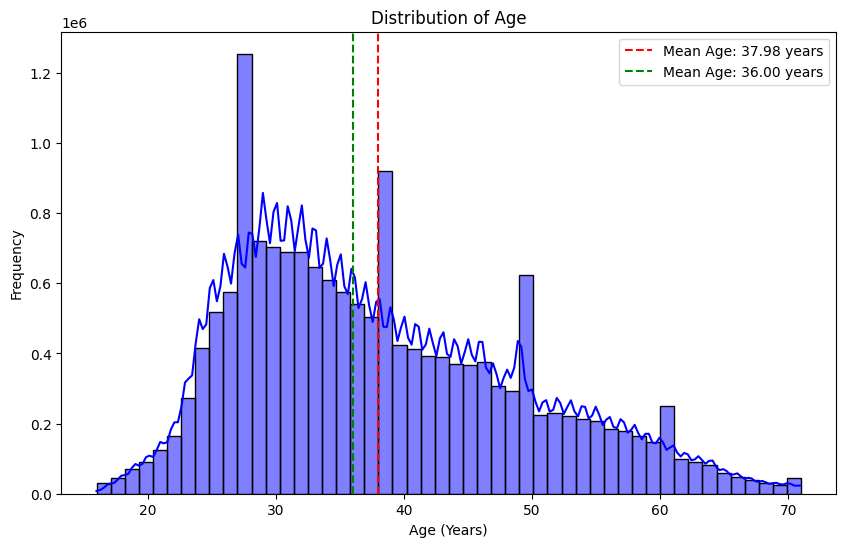

In [ ]:
#@title Distribution of age
# Calculating the median and the mean of age
median_age = trips['age'].median()
mean_age = trips['age'].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(trips['age'], bins=50, kde=True, color='Blue')
plt.axvline(mean_age, color='red', linestyle='--', label=f'Mean Age: {mean_age:.2f} years')
plt.axvline(median_age, color='green', linestyle='--', label=f'Mean Age: {median_age:.2f} years')
plt.title('Distribution of Age')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
#@title Distribution of Trips by Gender and Usertype
fig = px.histogram(trips, x="gender", color="usertype", barmode="group",
                   title="Distribution of Trips by Gender and Usertype",
                   labels={"gender": "Gender", "usertype": "User Type"},
                   width=800, height=600)
fig.show()


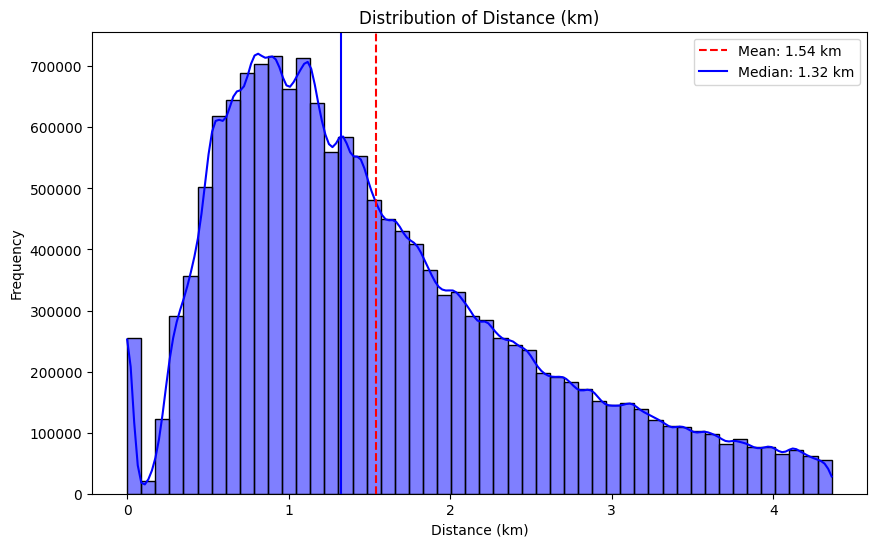

In [ ]:
# Calculating the mean and median of distance_km
mean_distance = trips['distance_km'].mean()
median_distance = trips['distance_km'].median()

# Plot distribution of distance_km
plt.figure(figsize=(10, 6))
sns.histplot(trips['distance_km'], bins=50, kde=True, color='Blue')
plt.axvline(mean_distance, color='red', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
plt.axvline(median_distance, color='blue', linestyle='-', label=f'Median: {median_distance:.2f} km')
plt.title('Distribution of Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Sort the values in descending order
top_start_stations = trips['start_station_name'].value_counts().sort_values(ascending=False)

# Sort the values in descending order
top_end_stations = trips['end_station_name'].value_counts().sort_values(ascending=False)

In [ ]:
# Merge top_start_stations and top_end_stations by index
trips_number_stations = top_start_stations.to_frame(name='start_station_count').merge(
    top_end_stations.to_frame(name='end_station_count'),
    left_index=True,
    right_index=True
)

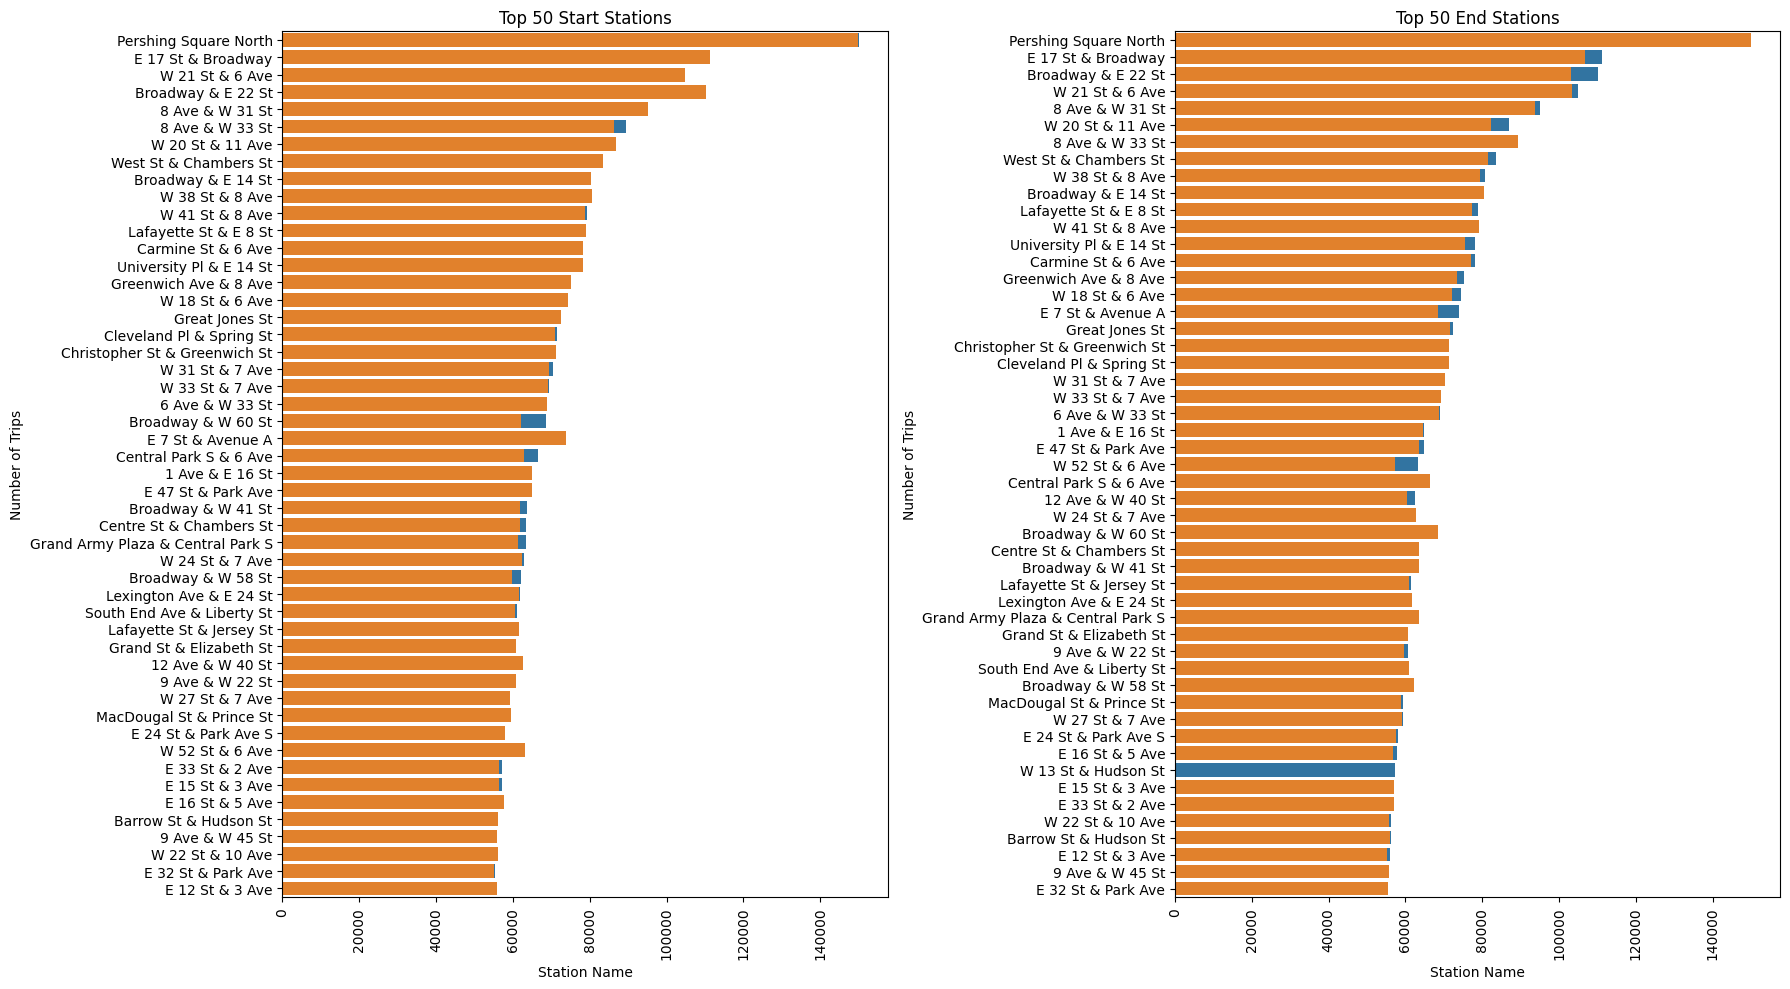

In [ ]:
# Get the top 50 start and end stations
top_50_start_stations = trips_number_stations.sort_values(by='start_station_count', ascending=False).head(50)
top_50_end_stations = trips_number_stations.sort_values(by='end_station_count', ascending=False).head(50)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot top 50 start stations
sns.barplot(x='start_station_count', y=top_50_start_stations.index, data=top_50_start_stations, ax=axes[0])
sns.barplot(x='end_station_count', y=top_50_start_stations.index, data=top_50_start_stations, ax=axes[0])
axes[0].set_title('Top 50 Start Stations')
axes[0].set_xlabel('Station Name')
axes[0].set_ylabel('Number of Trips')
axes[0].tick_params(axis='x', rotation=90)

# Plot top 50 end stations
sns.barplot(x='end_station_count', y=top_50_end_stations.index, data=top_50_end_stations, ax=axes[1])
sns.barplot(x='start_station_count', y=top_50_start_stations.index, data=top_50_start_stations, ax=axes[1])
axes[1].set_title('Top 50 End Stations')
axes[1].set_xlabel('Station Name')
axes[1].set_ylabel('Number of Trips')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
# Merge top_start_stations with trips to get latitude and longitude
top_start_stations_with_location = top_start_stations.to_frame(name='start_station_count').merge(
    trips[['start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates(),
    left_index=True,
    right_on='start_station_name',
    how='left'
)

,start_station_count,start_station_name,start_station_latitude,start_station_longitude
107,150029,Pershing Square North,40.751873,-73.977706
557,106789,E 17 St & Broadway,40.737050,-73.990093
0,103400,W 21 St & 6 Ave,40.741740,-73.994156
65,103093,Broadway & E 22 St,40.740343,-73.989551
270,93631,8 Ave & W 31 St,40.750585,-73.994685


In [ ]:
#@ Start stations on the map
fig = px.scatter_mapbox(top_start_stations_with_location, lat="start_station_latitude", lon="start_station_longitude",
                        hover_name="start_station_name", size="start_station_count",
                        color="start_station_count", zoom=10, height=600)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Exploration of trips duration

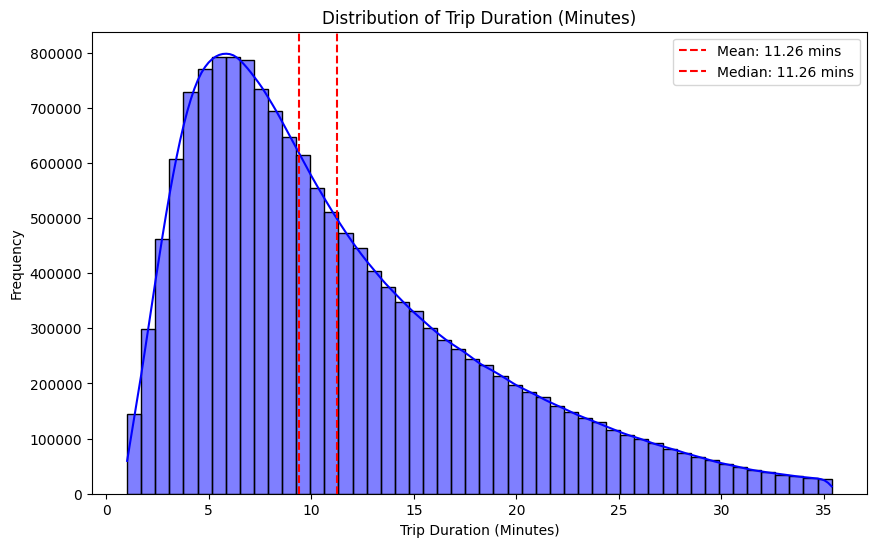

In [ ]:
# Calculate the mean trip duration (in minutes)
mean_trip_duration = trips['tripduration'].mean() / 60  # converting to minutes
median_trip_duration = trips['tripduration'].median() / 60
# Plot distribution of trip duration (in minutes)
plt.figure(figsize=(10, 6))
sns.histplot(trips['tripduration'] / 60, bins=50, kde=True, color='Blue')
# Add a vertical line for the mean
plt.axvline(mean_trip_duration, color='red', linestyle='--', label=f'Mean: {mean_trip_duration:.2f} mins')
plt.axvline(median_trip_duration, color='red', linestyle='--', label=f'Median: {median_trip_duration:.2f} mins')
plt.title('Distribution of Trip Duration (Minutes)')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Calculate the average trip duration by day of the week
avg_trip_duration_by_day = trips.groupby('day_of_week')['tripduration'].mean() / 60

# Create a bar chart using Plotly Express
fig_day = px.bar(
    x=avg_trip_duration_by_day.index,
    y=avg_trip_duration_by_day.values,
    labels={'x': 'Day of the Week', 'y': 'Average Trip Duration (Minutes)'},
    title='Average Trip Duration by Day of the Week',
    width=800, height=600
)
fig_day.update_layout(
    xaxis_tickvals=[1, 2, 3, 4, 5, 6, 7],
    xaxis_ticktext=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
)
fig_day.show()


# Calculate the average trip duration by hour of the day
avg_trip_duration_by_hour = trips.groupby('hour_of_day')['tripduration'].mean() / 60

# Create a bar chart using Plotly Express
fig_hour = px.bar(
    x=avg_trip_duration_by_hour.index,
    y=avg_trip_duration_by_hour.values,
    labels={'x': 'Hour of the Day', 'y': 'Average Trip Duration (Minutes)'},
    title='Average Trip Duration by Hour of the Day',
    width=800, height=600
)
fig_hour.show()


In [ ]:
trips['weekend_label'] = trips['day_of_week'].apply(lambda x: 'weekend' if x==7 or x==1 else 'workday')

In [ ]:
#@title Average Trip Duration per Day
average_tripduration_per_day = trips.groupby(['date', 'weekend_label'])['tripduration'].mean().reset_index(name='average_tripduration')

fig = px.bar(average_tripduration_per_day, x='date', y=average_tripduration_per_day['average_tripduration'] / 60, color='weekend_label',
             title='Average Trip Duration per Day',
             labels={'average_tripduration': 'Average Trip Duration (minutes)',
                     'date': 'Date',
                     'weekend_label': 'Day Type'})
fig.show()

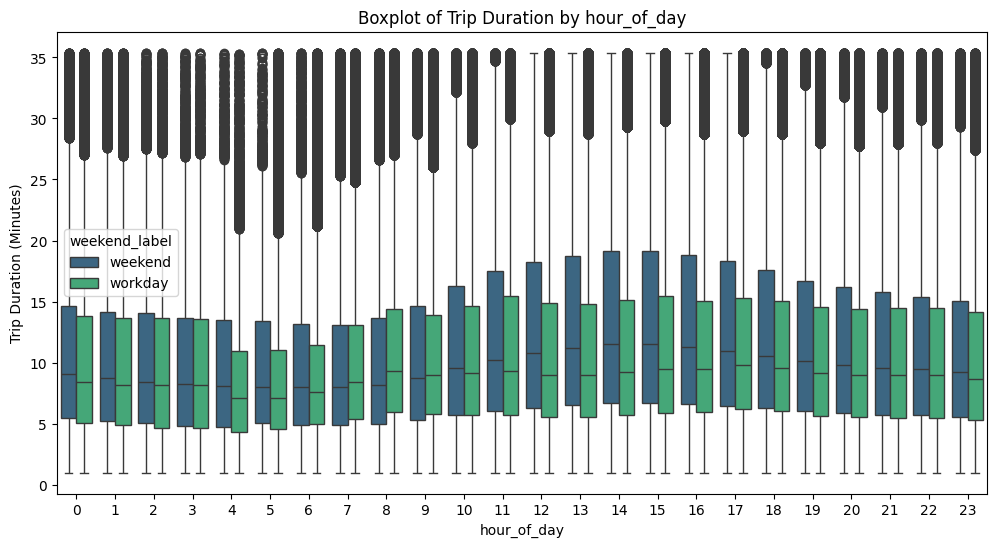

In [ ]:
# Creating a boxplot for trip duration by age group and gender
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour_of_day', y=trips['tripduration']/60, data=trips, palette='viridis', hue='weekend_label')
plt.title('Boxplot of Trip Duration across hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Trip Duration (Minutes)')
plt.show()

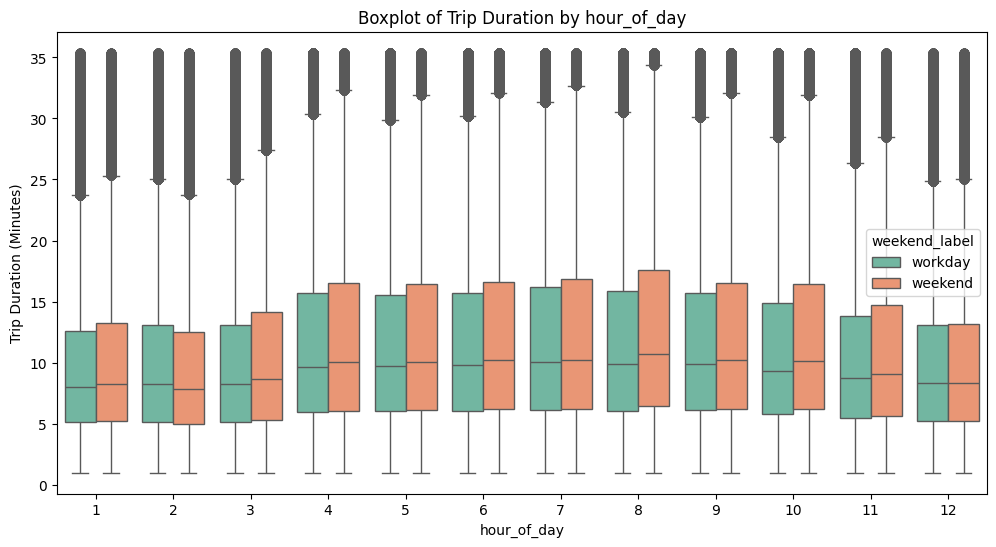

In [ ]:
# Creating a boxplot for trip duration by month and weekends
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y=trips['tripduration']/60, data=trips, hue='weekend_label' palette='Set2')
plt.title('Boxplot of Trip Duration by Month')
plt.xlabel('Month')
plt.ylabel('Trip Duration (Minutes)')
plt.show()

In [ ]:
# Function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Create a 'season' column
trips['season'] = trips['month'].apply(get_season)

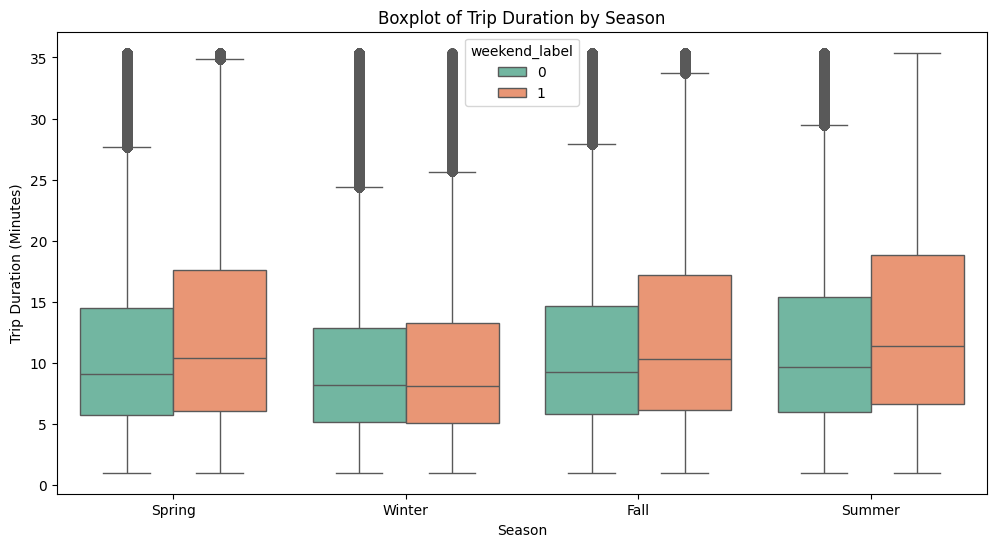

In [ ]:
# Creating a boxplot for trip duration by season and weekends
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y=trips['tripduration']/60, data=trips, hue='weekend_label', palette='Set2')
plt.title('Boxplot of Trip Duration by Season')
plt.xlabel('Season')
plt.ylabel('Trip Duration (Minutes)')
plt.show()

In [ ]:
#@title Average Trip Duration by Day of Week and Hour of Day

# Convert tripduration to numeric
trips['tripduration'] = pd.to_numeric(trips['tripduration'], errors='coerce')

# Group by both 'day_of_week' and 'hour_of_day' to get average trip duration
heatmap_data = trips.groupby(['day_of_week', 'hour_of_day']).agg({'tripduration': 'mean'}) / 60
heatmap_data = heatmap_data.unstack()

fig = px.imshow(heatmap_data,
                labels=dict(x="Hour of Day", y="Day of Week", color="Average Trip Duration"),
                x=heatmap_data.columns.get_level_values(1),
                y=heatmap_data.index,
                color_continuous_scale='Viridis',
                title='Average Trip Duration by Day of Week and Hour of Day',
                text_auto=".2f")

fig.update_layout(yaxis_tickvals=[1, 2, 3, 4, 5, 6, 7],
                  yaxis_ticktext=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

fig.show()

In [ ]:
#@title Statistical Test for Weekend vs. Workday Trip Duration
#@markdown **Null Hypothesis (H₀):** The average trip duration on weekends is equal to the average trip duration on weekdays \
#@markdown **Alternative Hypothesis (H₁):** The average trip duration on weekends is not equal to the average trip duration on weekdays

sample_size = 100000  # 100k rows from each category (weekend and workday)

# Random sampling for weekend and weekday trips
weekend_sample = trips[trips['weekend_label'] == 'weekend'].sample(n=sample_size, random_state=42)['tripduration']
weekday_sample = trips[trips['weekend_label'] == 'workday'].sample(n=sample_size, random_state=42)['tripduration']

weekend_sample = weekend_sample.astype(float)
weekday_sample = weekday_sample.astype(float)

# Perform the Independent Two-Sample t-Test
t_stat, p_value = stats.ttest_ind(weekend_sample, weekday_sample, equal_var=False)

# Print the test results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Check if we reject the null hypothesis
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis (H0). There is a significant difference in average trip duration between weekends and workdays.")
else:
    print("Fail to reject the null hypothesis (H0). There is no significant difference in average trip duration between weekends and workdays.")


T-Statistic: 45.82203020065253
P-Value: 0.0
Reject the null hypothesis (H0). There is a significant difference in average trip duration between weekends and workdays.


Since null hypothesis is rejected, this suggests that the average trip duration on weekends is significantly different from the average trip duration on workdays.

This result could be important for understanding user behavior, such as:
- Longer trips on weekends: People may use the service for leisure on weekends.
- Shorter trips on workdays: The service could be primarily used for commuting on workdays.

We should proceed with further analysis and add weekend_label to the model.

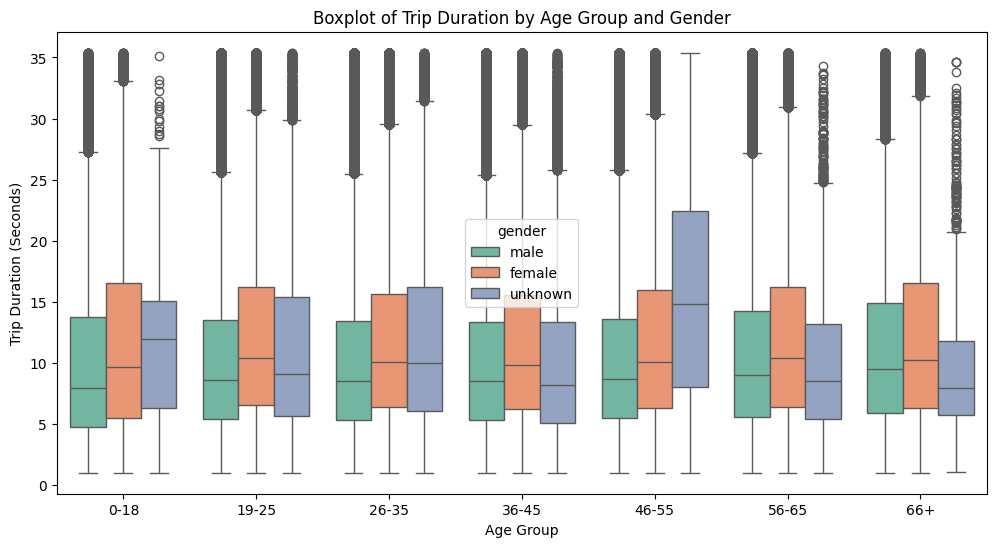

In [ ]:
# Create age bins
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
trips['age_group'] = pd.cut(trips['age'], bins=age_bins, labels=age_labels)

# Set up the plot
plt.figure(figsize=(12, 6))

# Create a boxplot for trip duration by age group and gender
sns.boxplot(x='age_group', y=trips['tripduration']/60, hue='gender', data=trips, palette='Set2')

# Add title and labels
plt.title('Distribution of Trip Duration by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Trip Duration (Minutes)')

# Show plot
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


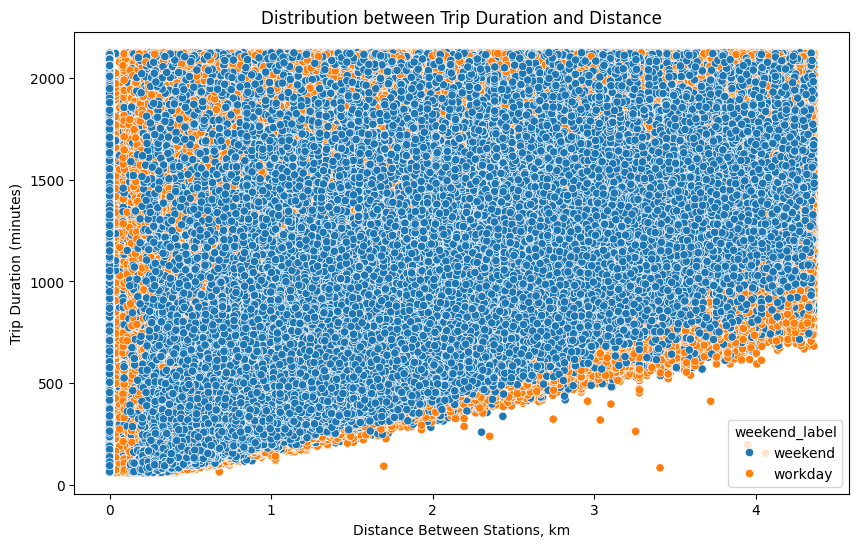

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y=trips['tripduration'], hue='weekend_label', data=trips)
plt.title('Distribution between Trip Duration and Distance')
plt.xlabel('Distance Between Stations, km')
plt.ylabel('Trip Duration (minutes)')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'trips' is your DataFrame containing 'tripduration', 'day_of_week', and 'distance_km'
trip_duration = trips['tripduration']
day_of_week = trips['day_of_week']  # Make sure this column represents day of the week
distance_km = trips['distance_km']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(day_of_week, trip_duration, distance_km, c=trip_duration, cmap='viridis', alpha=0.7)

# Adding labels and title
ax.set_xlabel('Day of Week')
ax.set_ylabel('Trip Duration (minutes)')
ax.set_zlabel('Distance (km)')
ax.set_title('Trip Duration across Day of Week and Distance')

# Add a color bar to show the values for trip duration
plt.colorbar(sc, label='Trip Duration (minutes)')

# Show the plot
plt.show()

## Data Transformation

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder object
le = LabelEncoder()

# Apply to start and end station names
trips['start_station_label'] = le.fit_transform(trips['start_station_name'])
trips['end_station_label'] = le.fit_transform(trips['end_station_name'])

KeyError: 'start_station_name'

In [ ]:
# Label encoding for gender
gender_mapping = {'male': 1, 'female': 2, 'unknown': 0}
trips['gender_label'] = trips['gender'].map(gender_mapping)

In [ ]:
usertype_mapping = {'Customer': 0, 'Subscriber': 1}
trips['usertype_label'] = trips['usertype'].map(usertype_mapping)
weekend_mapping = {'weekend': 1, 'workday': 0}
trips['weekend_label'] = trips['weekend_label'].map(weekend_mapping)

In [ ]:
# Convert the 'season' column to numerical values using label encoding
trips['season_encoded'] = trips['season'].astype('category').cat.codes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
trips[['tripduration', 'start_station_latitude', 'start_station_longitude',
       'end_station_latitude', 'end_station_longitude', 'distance_km', 'age']] = min_max_scaler.fit_transform(
       trips[['tripduration', 'start_station_latitude', 'start_station_longitude',
              'end_station_latitude', 'end_station_longitude', 'distance_km', 'age']])

In [ ]:
corr_matrix = trips[['tripduration', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'distance_km', 'age', 'gender_label', 'day_of_week', 'hour_of_day', 'usertype_label', 'season_encoded', 'month', 'weekend_label']].corr()

In [ ]:
fig = px.imshow(corr_matrix,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=corr_matrix.columns,
                y=corr_matrix.index,
                color_continuous_scale='RdBu',
                title='Correlation Matrix of Citibike Trips',
                text_auto=".2f",
                height=900)

fig.show()

In [ ]:
%%bigquery weather --project {project_id}
  SELECT
        DATE(
        CAST(year AS INT64),
        CAST(mo AS INT64),
        CAST(da AS INT64)
        ) AS date,
        temp,
        CASE
          WHEN wdsp='999.9' THEN null ELSE wdsp
        END AS wind_speed,
        CASE
          WHEN visib>100 THEN null ELSE visib
        END AS visibility,
        prcp AS precipitation
  FROM `bigquery-public-data.noaa_gsod.*`
  WHERE wban like '94728'
        AND year in ('2017', '2018')
  ORDER BY date

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
weather

,date,temp,wind_speed,visibility,precipitation
0,2017-01-01,44.8,5.0,10.0,0.00
1,2017-01-02,39.3,6.7,8.5,0.00
2,2017-01-03,40.1,11.2,3.8,0.30
3,2017-01-04,44.6,6.1,7.9,0.49
4,2017-01-05,31.4,7.0,10.0,0.00
...,...,...,...,...,...
725,2018-12-27,40.3,None,10.0,0.00
726,2018-12-28,48.8,None,5.5,0.18
727,2018-12-29,51.9,None,9.2,0.97
728,2018-12-30,37.4,None,9.5,0.00


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           730 non-null    dbdate 
 1   temp           730 non-null    float64
 2   wind_speed     646 non-null    object 
 3   visibility     727 non-null    float64
 4   precipitation  730 non-null    float64
dtypes: dbdate(1), float64(3), object(1)
memory usage: 28.6+ KB


In [ ]:
weather['wind_speed'] = weather['wind_speed'].astype(float)
weather['wind_speed'].fillna(weather['wind_speed'].mean(), inplace=True)
weather['visibility'].fillna(weather['visibility'].mean(), inplace=True)

In [ ]:
# Saving weather to csv for Tableau dashboard
weather.to_csv('weather.csv', index=False)


In [ ]:
trips = pd.merge(trips, weather, on='date', how='left')

In [ ]:
numerical_cols = ['tripduration', 'start_station_latitude', 'end_station_latitude', 'distance_km', 'age', 'gender_label', 'day_of_week', 'hour_of_day', 'usertype_label', 'season_encoded', 'month', 'temp', 'wind_speed', 'visibility', 'precipitation']

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='tripduration', data=trips)
plt.title('Trip Duration vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Trip Duration')
plt.show()


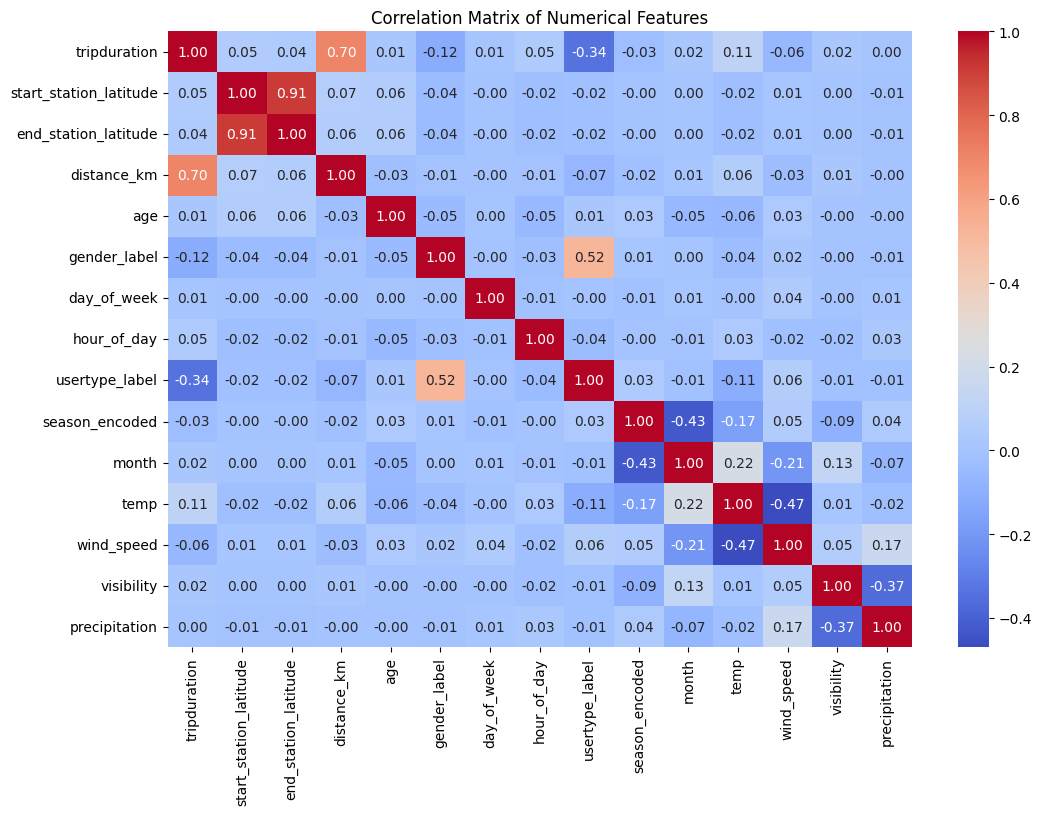

In [ ]:
corr_matrix = trips[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
numerical_cols = ['tripduration', 'start_station_latitude', 'end_station_latitude', 'distance_km', 'gender_label', 'hour_of_day', 'usertype_label', 'season_encoded', 'temp', 'wind_speed']

In [ ]:
trips = trips[numerical_cols]

In [ ]:
#@markdown Hypothesis (H0): The average trip duration in the sample is equal to the population mean. \
#@markdown Alternative Hypothesis (H1): The average trip duration in the sample is not equal to the population mean.

# Create a random sample (for example, 100,000 rows)
sample_size = 5000000
random_sample = trips.sample(n=sample_size, random_state=42)

# Calculate the population mean
population_mean = trips['tripduration'].mean()

# Perform a one-sample t-test
t_stat, p_value = stats.ttest_1samp(random_sample['tripduration'], population_mean)

# Print the test results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Check if we reject the null hypothesis
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. The average trip duration in the sample is significantly different from the population mean.")
else:
    print("Fail to reject the null hypothesis. The average trip duration in the sample is not significantly different from the population mean.")

T-Statistic: -1.067461635975411
P-Value: 0.2857634801490493
Fail to reject the null hypothesis. The average trip duration in the sample is not significantly different from the population mean.


## Training prediction model with Random Forest Regressor and Support Vector Regressor

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = random_sample.drop('tripduration', axis=1)
y = random_sample['tripduration']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
from sklearn.svm import SVR

# Create SVR model
svr = SVR(kernel='linear')  # You can experiment with different kernels

# Fit the model
svr.fit(X_train, y_train)

# Make predictions
svr_train_pred = svr.predict(X_train)
svr_test_pred = svr.predict(X_test)

# Evaluate the model
print('MSE train data: %.3f, MSE test data: %.3f' % (
    mean_squared_error(y_train, svr_train_pred),
    mean_squared_error(y_test, svr_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
    r2_score(y_train, svr_train_pred),
    r2_score(y_test, svr_test_pred)))
accuracy = svr.score(X_test, y_test)
print('Accuracy = '+ str(accuracy))

MSE train data: 0.018, MSE test data: 0.018
R2 train data: 0.580, R2 test data: 0.585
Accuracy = 0.5852798894462753


In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the model
forest = RandomForestRegressor(random_state=1)

# Define the parameter grid
param_grid = {
    'n_estimators': [50],
    'max_depth': [100],
    'min_samples_leaf': [30],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("Best MSE (negated) found by GridSearchCV:")
print(-grid_search.best_score_)

# Get the best model
best_grid_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_test_pred = best_grid_model.predict(X_test)
print('MSE test data: %.3f' % mean_squared_error(y_test, y_test_pred))
print('R2 test data: %.3f' % r2_score(y_test, y_test_pred))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found by GridSearchCV:
{'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'n_estimators': 50}
Best MSE (negated) found by GridSearchCV:
0.015823247005797462
MSE test data: 0.016
R2 test data: 0.633


In [ ]:
# Regression plot for the training set
plt.figure(figsize=(8, 4))
sns.regplot(x=y_train, y=tree_train_pred, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Regression Plot (Training Set)')
plt.show()

# Regression plot for the test set
plt.figure(figsize=(8, 4))
sns.regplot(x=y_test, y=tree_test_pred, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Regression Plot (Test Set)')
plt.show()